# Control of a stochastic double integrator

In [1]:
# Specify the cores to use for XLA
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

import jax
import jax.numpy as jnp
import diffrax
import jax.random as jr
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from jax import Array
from typing import Tuple, Callable
import copy

from kozax.genetic_programming import GeneticProgramming
from neuromorphic_intelligence.kozax_sdi import StochasticDoubleIntegrator

These device(s) are detected:  [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [ ]:
# set colormap
cmap = plt.get_cmap("tab10")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cmap.colors)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

Change log;
- reward parameters q and r set to 1 and 1 instead of 0.9 and 0.1
- we now iterate over multiple initializations

First we generate data, consisting of initial conditions, keys for noise, targets and parameters of the environment.

In [2]:
def get_data(key, env, batch_size, dt, T, param_setting):
    init_key, noise_key, param_key = jr.split(key, 3)
    x0, targets = env.sample_init_states(batch_size, init_key)
    noise_keys = jr.split(noise_key, batch_size)
    ts = jnp.arange(0, T, dt)

    params = env.sample_params(batch_size, param_setting, ts, param_key)
    
    # initial state of coupled system set to zero; target location always 0.0
    return jnp.zeros_like(x0), ts, jnp.zeros_like(targets), noise_keys, params 

key = jr.PRNGKey(0)
gp_key, data_key = jr.split(key)
batch_size = 16
T = 100
dt = 0.1
param_setting = "Constant"

env = StochasticDoubleIntegrator(process_noise = 0.1, obs_noise = 0.0)

data = get_data(data_key, env, batch_size, dt, T, param_setting)

The evaluator class parallelizes the simulation of the control loop over the batched data. In each trajectory, a coupled dynamical system is simulated using diffrax, integrating both the dynamic memory and the dynamic environment, defined by the drift and diffusion functions. At every time step, the state of the environment is mapped to observations and the latent memory is mapped to a control signal. Afterwards, the state equation of the memory and environment state is computed. When the simulation is done, the fitness is computed given the control and environment state.

In [3]:
class Evaluator:
    def __init__(self, env, state_size: int, dt0: float, solver=diffrax.Euler(), max_steps: int = 16**4, stepsize_controller: diffrax.AbstractStepSizeController = diffrax.ConstantStepSize()) -> None:
        """Evaluates dynamic symbolic policies in control tasks.

        Args:
            env: Environment on which the candidate is evaluated.
            state_size: Dimensionality of the hidden state.
            dt0: Initial step size for integration.
            solver: Solver used for integration (default: diffrax.Euler()).
            max_steps: The maximum number of steps that can be used in integration (default: 16**4).
            stepsize_controller: Controller for the stepsize during integration (default: diffrax.ConstantStepSize()).

        Attributes:
            env: Environment on which the candidate is evaluated.
            max_fitness: Max fitness which is assigned when a trajectory returns an invalid value.
            state_size: Dimensionality of the hidden state.
            obs_size: Dimensionality of the observations.
            control_size: Dimensionality of the control.
            latent_size: Dimensionality of the state of the environment.
            dt0: Initial step size for integration.
            solver: Solver used for integration.
            max_steps: The maximum number of steps that can be used in integration.
            stepsize_controller: Controller for the stepsize during integration.
        """
        self.env = env
        self.max_fitness = 1e4
        self.state_size = state_size
        self.obs_size = env.n_obs
        self.control_size = env.n_control_inputs
        self.latent_size = env.n_var*env.n_dim
        self.dt0 = dt0
        self.solver = solver
        self.max_steps = max_steps
        self.stepsize_controller = stepsize_controller

    def __call__(self, candidate: Array, data: Tuple, tree_evaluator: Callable) -> float:
        """Evaluates the candidate on a task.

        Args:
            candidate: The coefficients of the candidate.
            data: The data required to evaluate the candidate.
            tree_evaluator: Function for evaluating trees.

        Returns:
            Fitness of the candidate.
        """
        _, _, _, _, fitness = jax.vmap(self.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(candidate, *data, tree_evaluator)

        fitness = jnp.mean(fitness)
        return fitness
      
    def evaluate_trajectory(self, candidate: Array, x0: Array, ts: Array, target: float, noise_key: jr.PRNGKey, params: Tuple, tree_evaluator: Callable) -> Tuple[Array, Array, Array, Array, float]:
        """Solves the coupled differential equation of the system and controller. 
        The differential equation of the system is defined in the environment and the differential equation 
        of the control is defined by the set of trees.

        Args:
            candidate: Candidate with trees for the hidden state and readout.
            x0: Initial state of the system.
            ts: Time points on which the controller is evaluated.
            target: Target position that the system should reach.
            noise_key: Key to generate noisy observations.
            params: Parameters that define the environment.
            tree_evaluator: Function for evaluating trees.

        Returns:
            States, observations, control, activities of the hidden state of the candidate and the fitness of the candidate.
        """
        env = copy.copy(self.env)
        env.initialize_parameters(params, ts)

        state_equation = candidate[:self.state_size]
        readout = candidate[self.state_size:]
        
        solver = self.solver
        dt0 = self.dt0
        saveat = diffrax.SaveAt(ts=ts)

        process_noise_key, obs_noise_key = jr.split(noise_key, 2)

        # Concatenate the initial state of the system with the initial state of the latent memory
        _x0 = jnp.concatenate([x0, jnp.zeros(self.state_size)])

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(env.n_var,), key=process_noise_key, levy_area=diffrax.SpaceTimeLevyArea) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self._drift), diffrax.ControlTerm(self._diffusion, brownian_motion))
        
        # Solve the coupled system of the environment and the controller
        # We ignore the learnt initial state and. set to zero
        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, jnp.zeros_like(_x0), saveat=saveat, adjoint=diffrax.DirectAdjoint(), max_steps=self.max_steps, event=diffrax.Event(self.env.cond_fn_nan), 
            args=(env, state_equation, readout, obs_noise_key, target, tree_evaluator), stepsize_controller=self.stepsize_controller, throw=False
        )

        xs = sol.ys[:,:self.latent_size]
        # Get observations of the state at every time step
        _, ys = jax.lax.scan(env.f_obs, obs_noise_key, (ts, xs))

        activities = sol.ys[:,self.latent_size:]
        # Get control actions at every time step
        us = jax.vmap(lambda y, a, tar: tree_evaluator(readout, jnp.concatenate([y, a, jnp.zeros(self.control_size), target])), in_axes=[0,0,None])(ys, activities, target)

        # Compute the fitness of the candidate in this trajectory
        fitness = env.fitness_function(xs, us[:,None], target, ts)

        return xs, ys, us, activities, fitness
    
    def _drift(self, t, x_a, args):
        env, state_equation, readout, obs_noise_key, target, tree_evaluator = args
        x = x_a[:self.latent_size]
        a = x_a[self.latent_size:]

        _, y = env.f_obs(obs_noise_key, (t, x)) #Get observations from system
        u = tree_evaluator(readout, jnp.concatenate([jnp.zeros(self.obs_size), a, jnp.zeros(self.control_size), target])) #Compute control action from latent memory

        u = jnp.atleast_1d(u)

        dx = env.drift(t, x, u) #Apply control to system and get system change
        da = tree_evaluator(state_equation, jnp.concatenate([y, a, u, target])) #Compute change in latent memory

        return jnp.concatenate([dx, da])
    
    def _diffusion(self, t, x_a, args):
        env, state_equation, readout, obs_noise_key, target, tree_evaluator = args
        x = x_a[:self.latent_size]
        a = x_a[self.latent_size:]

        return jnp.concatenate([env.diffusion(t, x, jnp.array([0])), jnp.zeros((self.state_size, self.latent_size))]) #Only the system is stochastic

Here we define the hyperparameters, operators, variables and initialize the strategy. The control policy will consist of two latent variables and a readout layer. `layer_sizes` allows us to define different types of tree, where `variable_list` contains different sets of input variables for each type of tree. The readout layer will only receive the latent states, while the inputs to the state equations consists of the observations, control signal and latent states.

In [4]:
#Define hyperparameters
population_size = 100
num_populations = 10 # mention
num_generations = 50
state_size = 2

#Define expressions # UNIVERSAL?
operator_list = [("+", lambda x, y: x + y, 2, 0.5), 
                ("-", lambda x, y: x - y, 2, 0.1),
                ("*", lambda x, y: x * y, 2, 0.5)]

variable_list = [["x" + str(i) for i in range(env.n_obs)] + ["a1", "a2"], ["a1", "a2"]]

layer_sizes = jnp.array([state_size, env.n_control_inputs])

#Define evaluator # SHARK FOR SDE WITH ADDITIVE NOISE!
fitness_function = Evaluator(env, state_size, dt, solver=diffrax.GeneralShARK(), max_steps=1000)

#Initialize strategy
strategy = GeneticProgramming(num_generations, population_size, fitness_function, operator_list, variable_list, layer_sizes, num_populations = num_populations, size_parsimony=0.003)

# strategy.fit(gp_key, data, verbose=True)

Input data should be formatted as: ['x0', 'x1', 'a1', 'a2'].


In [ ]:
XS0 =[]
XS = []
FBEST = []

for i in range(20):

    # Sample the initial population
    key, gp_key = jr.split(jr.PRNGKey(0))
    population = strategy.initialize_population(gp_key)

    F = []
    F_best = []

    for g in range(num_generations):
        key, eval_key, sample_key = jr.split(key, 3)

        # Evaluate the population on the data, and return the fitness
        fitness, population = strategy.evaluate_population(population, (data), eval_key)

        F.append(-fitness)

        # if (g%5)==0:
        #     print("Generation:", g)
        #     strategy.print_pareto_front()

        # Evolve the population until the last generation. The fitness should be given to the evolve function.
        if g < (num_generations-1):
            population = strategy.evolve_population(population, fitness, sample_key)

    F = jnp.stack(F) # generation, subpopulation_nr, population_size

    F_best = []
    for g in range(num_generations):
        best_fitness, best_solution = strategy.get_statistics(g+1)
        F_best.append(-best_fitness)
        print(strategy.expression_to_string(best_solution))

    # compute performance on test data

    test_data = get_data(jax.random.PRNGKey(1), env, batch_size, dt, T, param_setting)

    for i in range(num_generations):
        best_fitness, best_solution = strategy.get_statistics(i+1)
        xs, ys, us, activities, fitness = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(best_solution, *test_data, strategy.tree_evaluator)
        F_best[i] = -jnp.mean(fitness)

    initial_fitness, initial_solution = strategy.get_statistics(1)
    xs0, ys0, us0, activities0, fitness0 = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(initial_solution, *data, strategy.tree_evaluator)
    print(-jnp.mean(fitness0))

    # final best solution
    final_fitness, final_solution = strategy.get_statistics(num_generations)
    xs, ys, us, activities, fitness = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(best_solution, *data, strategy.tree_evaluator)
    print(strategy.expression_to_string(final_solution))
    print(-jnp.mean(fitness))

    # store results
    XS0.append(xs0)
    XS.append(xs)
    FBEST.append(F_best)
    

[x1, (0.66*a1 - a2)*(x0 - 0.373), -1.18*a1]
[-0.597*x1, a2*(-a1 - 1.29), a1*(a2 + 1.63)]
[x1, a1**3*(x1 + 0.999), -1.07*a1]
[x1, a1**3*(x1 + 0.999), -1.07*a1]
[x1, a1**3*(x1 + 0.999), a1*(2*a2 - 1.07)]
[x1, a1**3*(x1 + 0.999), a1*(2*a2 - 1.07)]
[a2 + 0.33*x1, -1.54*a2 - 0.988*x1, a1 + 5.56*a2]
[a2 + 0.33*x1, -1.54*a2 - 0.988*x1, a1 + 5.56*a2]
[a2 + 0.33*x1, -1.54*a2 - 0.988*x1, a1 + 5.56*a2]
[a2 + 0.33*x1, -1.54*a2 - 0.988*x1, a1 + 5.56*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 1.98*a2]
[a2 - 0.0498*x1, -1.54*a2 - 0.988*x1, a1 + 3*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -1.54*a2 - 0.988*x1, 0.989*a1 + 2.97*a2]
[a2, -3.09*a2 - 0.988*x1, 1.98*a1 + 4.94*a2]
[a2, -3.09*a2 - 0.988*x1, 1.98*a1 + 4.94*a2]
[a

In [6]:
strategy.print_pareto_front()

Complexity: 3, fitness: 1004.3812866210938, equations: [a2, a2, a1]


Complexity: 5, fitness: 19.568790435791016, equations: [x1, 0.999, -1.07*a1]
Complexity: 7, fitness: 18.301481246948242, equations: [-0.0674*a1 - x1, a2, a1]
Complexity: 9, fitness: 14.585186958312988, equations: [x1, -a2 + x1, -1.08*a1 - 1.08*a2]
Complexity: 11, fitness: 13.44167423248291, equations: [a2, -2*a2 + x1, -1.8*a1 - 1.8*a2]
Complexity: 13, fitness: 11.84735107421875, equations: [x1, -2*a2 + x1, -0.799*a1 - 1.8*a2]
Complexity: 17, fitness: 11.13228702545166, equations: [x1, -3*a2 + x1, -0.799*a1 - 3.6*a2]
Complexity: 19, fitness: 10.853492736816406, equations: [x1, -4*a2 + x1, -0.799*a1 - 3.6*a2]
Complexity: 23, fitness: 10.569459915161133, equations: [x1, -5*a2 + x1, -0.799*a1 - 5.4*a2]
Complexity: 25, fitness: 10.507609367370605, equations: [x1, -6*a2 + x1, -0.799*a1 - 5.4*a2]
Complexity: 27, fitness: 10.483206748962402, equations: [x1, -6*a2 + x1, -0.799*a1 - 7.2*a2]
Complexity: 29, fitness: 10.32967472076416, equations: [x1, -7*a2 + x1, -0.799*a1 - 7.2*a2]
Complexity: 31

In [7]:
# # compute performance on test data

# test_data = get_data(jax.random.PRNGKey(1), env, batch_size, dt, T, param_setting)

# for i in range(num_generations):
#     best_fitness, best_solution = strategy.get_statistics(i+1)
#     xs, ys, us, activities, fitness = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(best_solution, *test_data, strategy.tree_evaluator)
#     F_best[i] = -jnp.mean(fitness)

# initial_fitness, initial_solution = strategy.get_statistics(1)
# xs0, ys0, us0, activities0, fitness0 = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(initial_solution, *data, strategy.tree_evaluator)
# print(-jnp.mean(fitness0))

# # final best solution
# final_fitness, final_solution = strategy.get_statistics(num_generations)
# xs, ys, us, activities, fitness = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[None, 0, None, 0, 0, 0, None])(best_solution, *data, strategy.tree_evaluator)
# print(strategy.expression_to_string(final_solution))
# print(-jnp.mean(fitness))

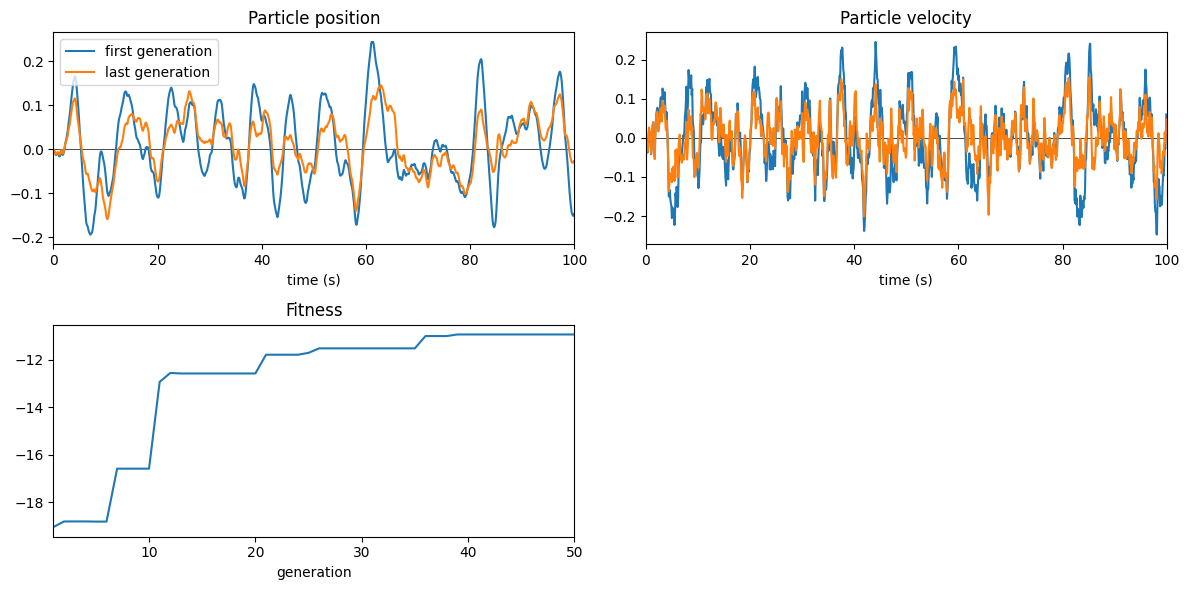

In [8]:
xs0 = XS0[0]
xs = XS[0]
F_best = FBEST[0]

ts = jnp.arange(0, T, dt)

fig, ax = plt.subplots(2, 2, figsize=(12,6))

ax[0,0].plot([0, T], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
ax[0,0].plot(ts, xs0[0,:,0],label='first generation')
ax[0,0].plot(ts, xs[0,:,0],label='last generation')
ax[0,0].legend()
ax[0,0].set_title('Particle position');
ax[0,0].set_xlabel('time (s)')

ax[0,1].plot([0, T], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
ax[0,1].plot(ts, xs0[0,:,1],label='first generation')
ax[0,1].plot(ts, xs[0,:,1],label='last generation')
ax[0,1].set_title('Particle velocity');
ax[0,1].set_xlabel('time (s)')

ax[1,0].plot(jnp.arange(num_generations)+1, F_best, label='no learning')
ax[1,0].set_title('Fitness');
ax[1,0].set_xlabel('generation')

for i in range(2):
    for j in range(2):
        ax[i,j].margins(x=0)

ax[1,1].axis('off')

plt.tight_layout()

plt.savefig('../figures/differential_genetic_programming.pdf', format='pdf')